In [11]:
%matplotlib inline

In [12]:
import pulp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import pandas as pd
import numpy as np
from random import shuffle
from mpl_toolkits.mplot3d import Axes3D

In [17]:
# Hyper Parameters
LR = 0.02                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
LAMBDA = 0.9                # parameter decay

N_ACTIONS = 10 #no. of duty cycles (0,1,2,3,4)
BMIN = 0.0
BMAX = 20000.0 #Battery capacity
BOPT = 0.6 * BMAX #Assuming 60% of battery is the optimal level
HMAX = 1000

In [18]:
class ENO(object):
    def __init__(self, year=2010):
        self.year = year
        self.day = None
        self.hr = None
        
        self.TIME_STEPS = None
        self.NO_OF_DAYS = None
        
        self.BMIN = BMIN
        self.BMAX = BMAX #Battery capacity
        self.BOPT = 0.6 * self.BMAX #Assuming 60% of battery is the optimal level
        self.HMAX = HMAX
        
        self.senergy = None #matrix with harvested energy data for the entire year
        self.fforecast = None #matrix with forecast values for each day
        
        self.batt = None #battery variable
        self.enp = None #enp at end of hr
        self.henergy = None #harvested energy variable
        self.fcast = None #forecast variable
    
    #function to map total day energy into day_state
    def get_day_state(self,tot_day_energy):
        if (tot_day_energy < 2500):
            day_state = 0
        elif (2500 <= tot_day_energy < 5000):
            day_state = 1
        elif (5000 <= tot_day_energy < 8000):
            day_state = 2
        elif (8000 <= tot_day_energy < 10000):
            day_state = 3
        elif (10000 <= tot_day_energy < 12000):
            day_state = 4
        else:
            day_state = 5
        return int(day_state)

    #function to get the solar data for the given year and prep it
    def get_data(self):
        filename = str(self.year)+'.csv'
        #skiprows=4 to remove unnecessary title texts
        #usecols=4 to read only the Global Solar Radiation (GSR) values
        solar_radiation = pd.read_csv(filename, skiprows=4, encoding='shift_jisx0213', usecols=[4])
        
        #convert dataframe to numpy array
        solar_radiation = solar_radiation.values
        solar_energy = np.array([i *0.0165*1000000*0.15*1000/(60*60) for i in solar_radiation])
        
        #reshape solar_energy into no_of_daysx24 array
        _senergy = solar_energy.reshape(-1,24)
        _senergy[np.isnan(_senergy)] = 0 #convert missing data in CSV files to zero
        self.senergy = np.clip(_senergy,0,self.HMAX) #limit the amount of harvested energy to HMAX        
        
        #create a perfect forecaster
        tot_day_energy = np.sum(_senergy, axis=1) #contains total energy harvested on each day
        get_day_state = np.vectorize(self.get_day_state)
        self.fforecast = get_day_state(tot_day_energy)
        
        return 0
    
    def reset(self):
        
        self.get_data() #first get data for the given year
        
        self.TIME_STEPS = self.senergy.shape[1]
        self.NO_OF_DAYS = self.senergy.shape[0]
        
        print("Environment is RESET")
        
        self.day = 0
        self.hr = 0
        
        self.batt = self.BOPT #battery returns to optimal level
        self.enp = self.BOPT - self.batt #enp is reset to zero
        self.henergy = self.senergy[self.day][self.hr] 
        self.fcast = self.fforecast[self.day]
        
        state = [self.batt/self.BMAX, self.enp/(self.BMAX/2), self.henergy/self.HMAX, self.fcast/5] #normalizing all state values within [0,1] interval
        reward = 0
        done = False
        info = "RESET"
        return [state, reward, done, info]
    
    
    #reward function
    def rewardfn(self):
        mu = 0
        sig = 1000
        if(np.abs(self.enp) <= 2400): #24hr * 100mW/hr
            return ((1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((self.enp - mu)/sig, 2.)/2)) * 1000000)
        else:
            return -100 - 0.05*np.abs(self.enp)
    
    def step(self, action):
        done = False
        info = "OK"
#         print("Next STEP")
        
        reward = 0
        e_consumed = (action+1)*500/N_ACTIONS
        
        self.batt += (self.henergy - e_consumed)
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX)
        self.enp = self.BOPT - self.batt
        
        if(self.hr < self.TIME_STEPS - 1):
            self.hr += 1
            self.henergy = self.senergy[self.day][self.hr] 
        else:
            if(self.day < self.NO_OF_DAYS -1):
                reward = self.rewardfn() #give reward only at the end of the day
                self.hr = 0
                self.day += 1
                self.henergy = self.senergy[self.day][self.hr] 
                self.fcast = self.fforecast[self.day]
            else:
                reward = self.rewardfn()
                done = True
                info = "End of the year"
                
        _state = [self.batt/self.BMAX, self.enp/(self.BMAX/2), self.henergy/self.HMAX, self.fcast/5]
        #we normalize the enp w.r.t. half of the battery level
        #this may give weird results if BOPT varies by a great amount from 0.5*BMAX
        
        return [_state, reward, done, info]

In [25]:
class SARSA(object):
    def __init__(self):
        self.no_of_batt_state = 3;
        self.no_of_enp_state = 42;
        self.no_of_henergy_state = 30;
        self.no_of_day_state = 6;
        self.no_of_actions = N_ACTIONS;
        self.q_init = 200;
        self.q = np.zeros((self.no_of_batt_state, self.no_of_enp_state, self.no_of_henergy_state, self.no_of_day_state, self.no_of_actions)) + self.q_init
        self.e = np.zeros_like(self.q)

    
    def get_batt_state(batt):
        if (batt < 0.3):
            batt_state = 0
        elif (0.3<= batt <0.8):
            batt_state = 1
        else:
            batt_state = 2
        
        return int(batt_state)
    
    def get_enp_state(enp):
        #assuming the battery deviates equally in both enp directions
        #NEEDS TO BE RETHOUGHT AND UPDATED
#         enp_max = 0.5
#         enp_min = 0
        
        enp = np.clip(enp,-0.5,0.5)
        _enp = 0.5 + enp
        enp_state = np.ceil(_enp*self.no_of_enp_state)
        
        enp_state = np.clip(enp_state, 0, self.no_of_enp_state-1)
        return int(enp_state)
    
    def get_henergy_state(henergy):
        henergy_state = int(np.floor(henergy*self.no_of_henergy_state))
        henergy_state = np.clip(henergy_state, 0, self.no_of_henergy_state-1)
        return int(henergy_state)

    
    def choose_action(s, q):
        [batt_state, enp_state, henergy_state, day_state] = s
        # This is how to choose an action
        q_values = q[batt_state, enp_state, henergy_state,  day_state, :]
        max_q_value = np.max(q_values)
        max_action = np.argmax(q_values)
        if (np.random.uniform() < epsilon) or ((q_values == 0).all()):  # select randomly if exploring or 
                                                                             #if state-action values are ALL zero
            action = np.random.randint(1,no_of_actions)
        else:   # act greedy
            action = max_action
        return int(action)
    

In [29]:
eno = ENO(2010)
eno.reset()
sarsa = SARSA()

Environment is RESET


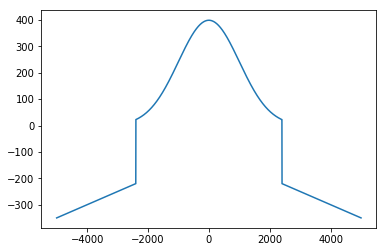

In [34]:
#Check reward function
y = np.empty(1)
for x in np.arange(-5000,5000):
    eno.enp = x
    y = np.append(y,eno.rewardfn())
    
y = np.delete(y, 0, 0) #remove the first row which is garbage

plt.plot(np.arange(-5000,5000),y)

In [ ]:
#Check state discretiziation functions